<span style=" font-size:3em;">MOD600 23V | Mandatory Project A</span>

<span style=" font-size:2em;">DISPLACEMENT OF TWO FLUIDS DESCRIBED THROUGH A NONLINEAR CONSERVATION LAW</span>

<span style=" font-size:1.5em;"> Daniel Fylling </span>  



### Task 1

<img src="fig/part1.jpg" width=350><p style="font-size: 0.9em"><i></i></p>
<img src="fig/part2.jpg" width=350><p style="font-size: 0.9em"><i></i></p>
<img src="fig/part3.jpg" width=350><p style="font-size: 0.9em"><i></i></p>

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
from envelope import *
%matplotlib inline

### Task 1 (iii)
Plot f(s) for different M.

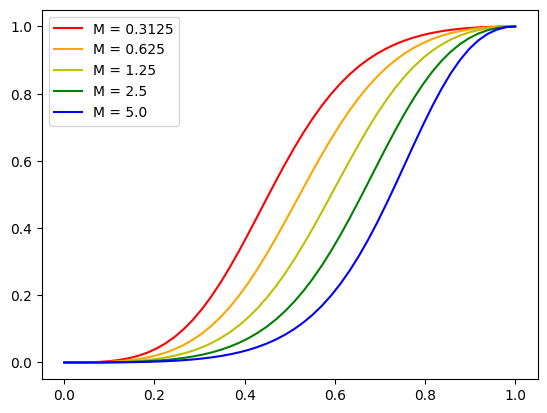

In [66]:
ns = 50 # nunmber of saturation grid points
s_all = np.linspace(0, 1, ns)
M_all = np.array([0.3125, 0.625, 1.25, 2.5, 5]) # viscosity coefficient

def f_s(s, m=2, nw=3, no=2):
    return s**nw/(s**nw+m*(1-s)**no)

colors = ['r','orange','y','g','b']    
for i, mi in enumerate(M_all):
    plt.plot(s_all, f_s(s=s_all,m=mi), color = colors[i], label=f'M = {mi}')
    plt.legend()

Not strictly adhering to range of M given in task, but I could not resist the symmetry of the ladder of power 2.
Since water viscosity is generally less than oil, we would expect to be in the red-orange-(yellow) region rather than bluer end.

### Task 2 (i)
Analytical solution at T = 0.5

In [67]:
# Spatial grid
x_min = 0
x_max = 1
length = x_max - x_min
nx = 300
dx = length/nx
x = np.linspace(x_min + dx/2, x_max-dx/2, nx)

# Temporal grid
t_final = 0.5 # serves as both final time of numerical calculation and exact time for analytical solution
nt = 300 
dt = t_final/nt

# define vector for initial data, used for numerical calculation
s0 = np.zeros(nx)
L1 = np.logical_and(x > 0 , x <= 0.1)
L2 = np.logical_and(x > 0.1 , x <= 1)
s0[L1] = 1
s0[L2] = 0

# h - useful quantity for the numerical calculation
a = 1
if a*dt > dx:
    print('Decrease dt')

h = (dt/dx)*a

In [68]:
# constructed a function to process input data and return relevant parameters for visualisation:

def Riemann(xR, v_l, v_r, nv, f, *args):
    v = np.linspace(v_l, v_r, nv)

    points = np.c_[v, f(v, *args)]

    # compute envelope depending on jump direction , +/-
    if v_l < v_r:
        envelope = lower_convex(points)
        Label = 'Lower Convex'
        [ev, ef] = np.array(envelope).T
    else:
        envelope = upper_concave(points)
        Label = 'Upper Concave'
        [ev, ef] = np.array(envelope).T
        ev = np.flip(ev)
        ef = np.flip(ef)

    # compute a velocity s_i for each v_i based on envelope
    speed_l = np.zeros(len(ev))
    speed_l[0] = (ef[1]-ef[0])/(ev[1]-ev[0])
    speed_l[1:-1] = (ef[2:]-ef[:-2])/(ev[2:]-ev[:-2]) 
    speed_l[-1] = (ef[-1]-ef[-2])/(ev[-1]-ev[-2])

    # compute the travelled distance from x_l
    xr = np.zeros(len(ev))
    xr = xR + speed_l*t_final
    return v, ev, ef, Label, xr

In [69]:
# Give Riemann data for jump

xR  = 0.1   # position of jump
v_l = 1     # u-value on left side of jump
v_r = 0     # u-value on right side of jump
nv = 50     # Number of values to divide jump, [vl,vr], into
f = f_s     # Specify f(u)
M = 0.5

Text(0, 0.5, 'Saturation')

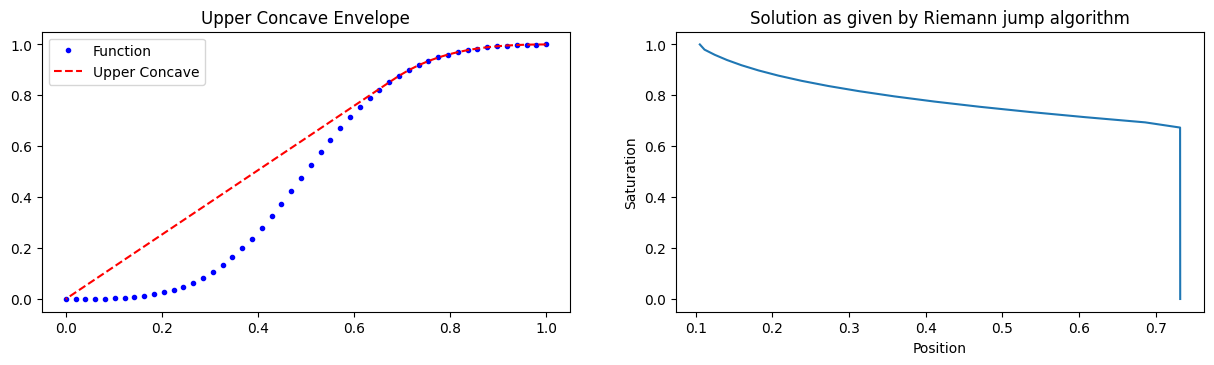

In [70]:
v, ev, ef, Label, xr = Riemann(xR, v_l, v_r, nv, f, M)

plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
plt.plot(v, f(v, M), 'b.', label = 'Function')
plt.plot(ev, ef, 'r--', label = Label)
plt.title(Label + ' Envelope')
plt.legend()

plt.subplot(2,2,2)
plt.plot(xr, ev)
plt.title('Solution as given by Riemann jump algorithm')
plt.xlabel('Position')
plt.ylabel('Saturation')

Text(0, 0.5, 'Saturation')

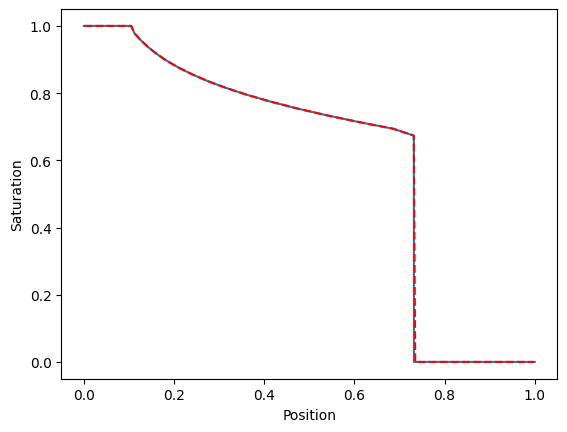

In [71]:
# extanding coordinates for the solution to contain full range of x-values:
xM = np.concatenate(([x_min], xr, [x_max]))
uM = np.concatenate(([1], ev, [0]))

# transforming solution back to original x-grid locations:
u_sol = np.interp(x, xM, uM)

# plotting both representations of the solution to see if the transformation back was a success:
plt.plot(xM, uM)
plt.plot(x, u_sol, '--r')
plt.xlabel('Position')
plt.ylabel('Saturation')

We can observe that the red dotted line representing the transformed solution does not have a completely vertical front. This is due to the original x-grid not having two x-values at the same point, as could be done in the exact solution. The courser the x-grid, the more deviation would be observed from vertical.

Below we will investigate the sensitivity toward the resolution on the x-grid.

*Note that x- and ylabels are not displayed in the comarison plots, as that makes the figure look unnecessarily busy.

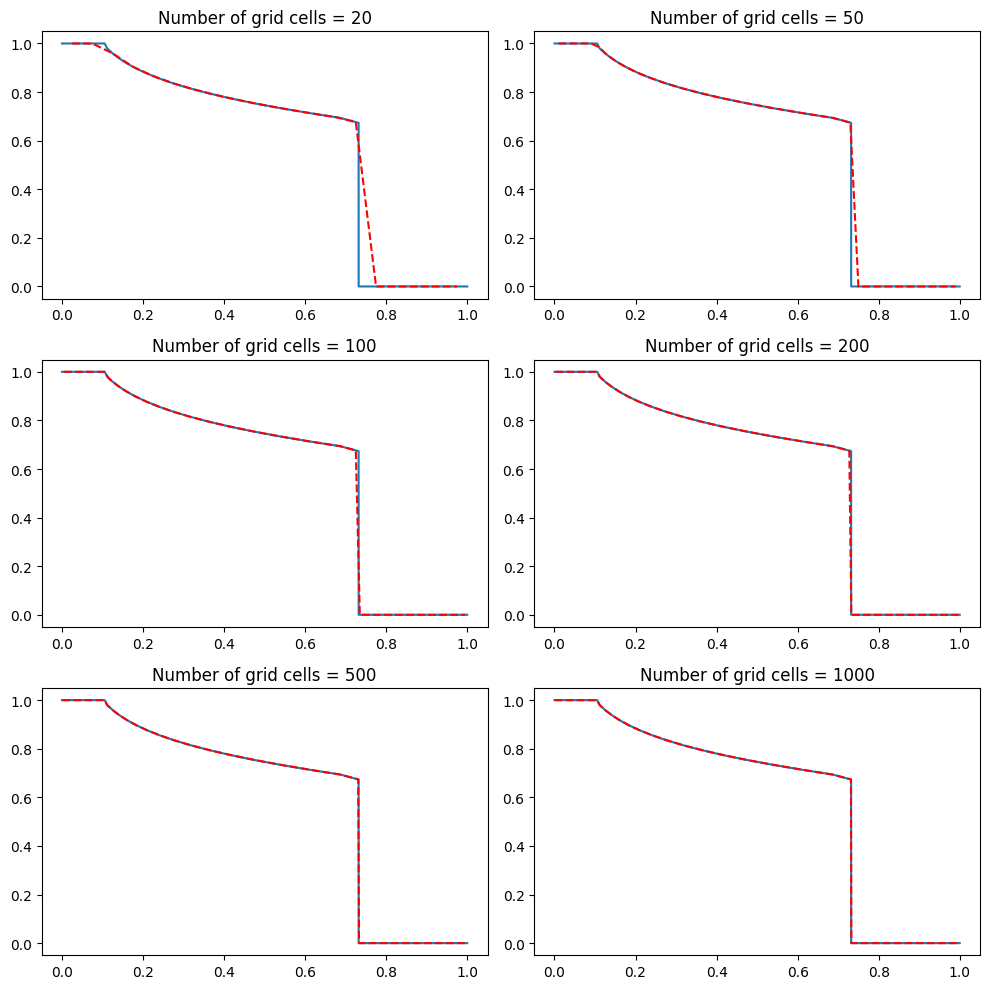

In [72]:
plt.figure(figsize=(10,10))

nx_all = [20, 50, 100, 200, 500, 1000]

for i, nx in enumerate(nx_all):
    dx = length/nx
    x = np.linspace(x_min + dx/2, x_max-dx/2, nx)
    
    u_sol = np.interp(x, xM, uM)

    plt.subplot(3,2,i+1)
    plt.plot(xM, uM)
    plt.plot(x, u_sol, '--r')
    plt.title(f'Number of grid cells = {nx_all[i]}')

plt.tight_layout()

From the above we can see that depending on accuracy requirement a suitable grid resolution can be chosen.
If optimizing toward computational speed for some reason, we see that even 50-100 grid point give a fairly good representation.
We can see that increasing resolution beyond 500 does not seem to add any value.

### Task 2 (ii)
Numerical solution at T = 0.5

In [73]:
# calculate the numerical solution u by going through a loop of nt number of time steps
# *args is used to sometimes pass M through this function as an argument into f()
 
def Numerical(u0, h, nt, *args):
    u_old = u0.copy()
    u_all = u_old.copy()

    for j in range(nt-1):
        # calculate solution at interior part of domain, that is, cells j=1,...,N-1  
        u_old[1:-1] = u_old[1:-1] - h*(f(u_old[1:-1], *args) - f(u_old[0:-2], *args))
        # solution at left boundary
        u_old[0] = u0[0]
        # solution at right boundary
        u_old[-1] = u0[-1]

        u_all = np.c_[u_all, u_old]
    return u_all

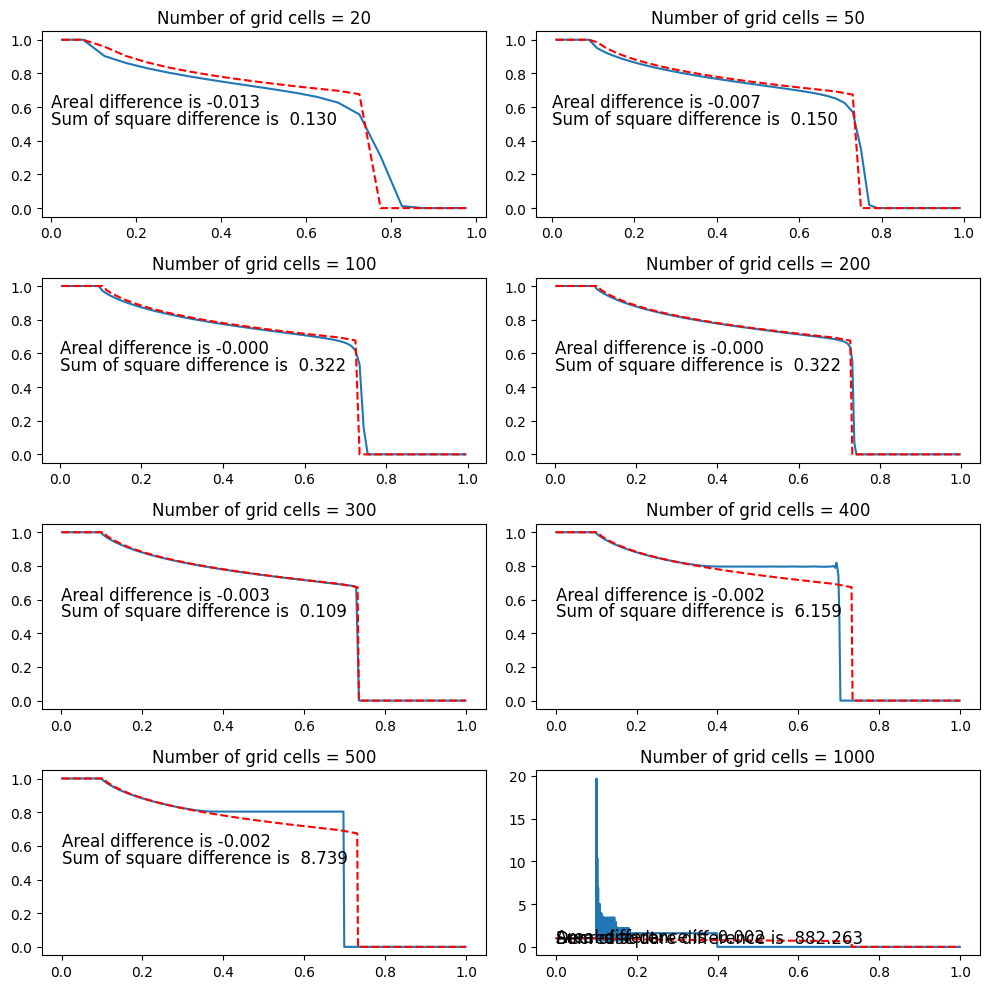

In [74]:
plt.figure(figsize=(10,10))

nx_all = [20, 50, 100, 200, 300, 400, 500, 1000]

for i, nx in enumerate(nx_all):
    dx = length/nx
    x = np.linspace(x_min + dx/2, x_max-dx/2, nx)

    s0 = np.zeros(nx)
    L1 = np.logical_and(x > 0 , x <= 0.1)
    L2 = np.logical_and(x > 0.1 , x <= 1)
    s0[L1] = 1
    s0[L2] = 0

    a = 1
    h = (dt/dx)*a
    
    u_sol = np.interp(x, xM, uM)
    u_num = Numerical(s0, h, nt, M)

    plt.subplot(4,2,i+1)
    plt.plot(x, u_num[:,-1])
    plt.plot(x, u_sol, '--r')
    plt.title(f'Number of grid cells = {nx}')
    plt.text(0, 0.6, f'Areal difference is {np.sum((u_num[:,-1]-u_sol)*dx):.3f}', fontsize=12)
    plt.text(0, 0.5, f'Sum of square difference is  {np.sum((u_num[:,-1]-u_sol)**2):.3f}', fontsize=12)
    if a*dt > dx:
        plt.text(0, 0.5, 'Decrease dt', fontsize=12)

plt.tight_layout()

Observations:
1. Areal difference is generally close to zero for all numbers of grid cells. Since both models are built on conservation laws this is expected.
2. 'Sum of square difference' is not necessarily that reliable as a measure of accuracy here since each iteration of the numerical model is compared against the analytical model with a corresponding grid resolution. This is why the sum of square difference can be lower for a low number of grid cells. Compared to the true solution we would expect this number to only decrease with increasing resolution.
3. Not sure what breaks the model at 400 and 500 grid cells. As the a*dt is less than dx I did not expect this.
4. At 1000 grid cells the model completely breaks, and I believe this is due to the a*dt > dx issue.

To investigate point number 2. further, the code was modified a bit and run again. The new code transforms the numerical solution at any given resolution across to a fixed 500 grid and compares to the analytical solution at the same 500 grid:

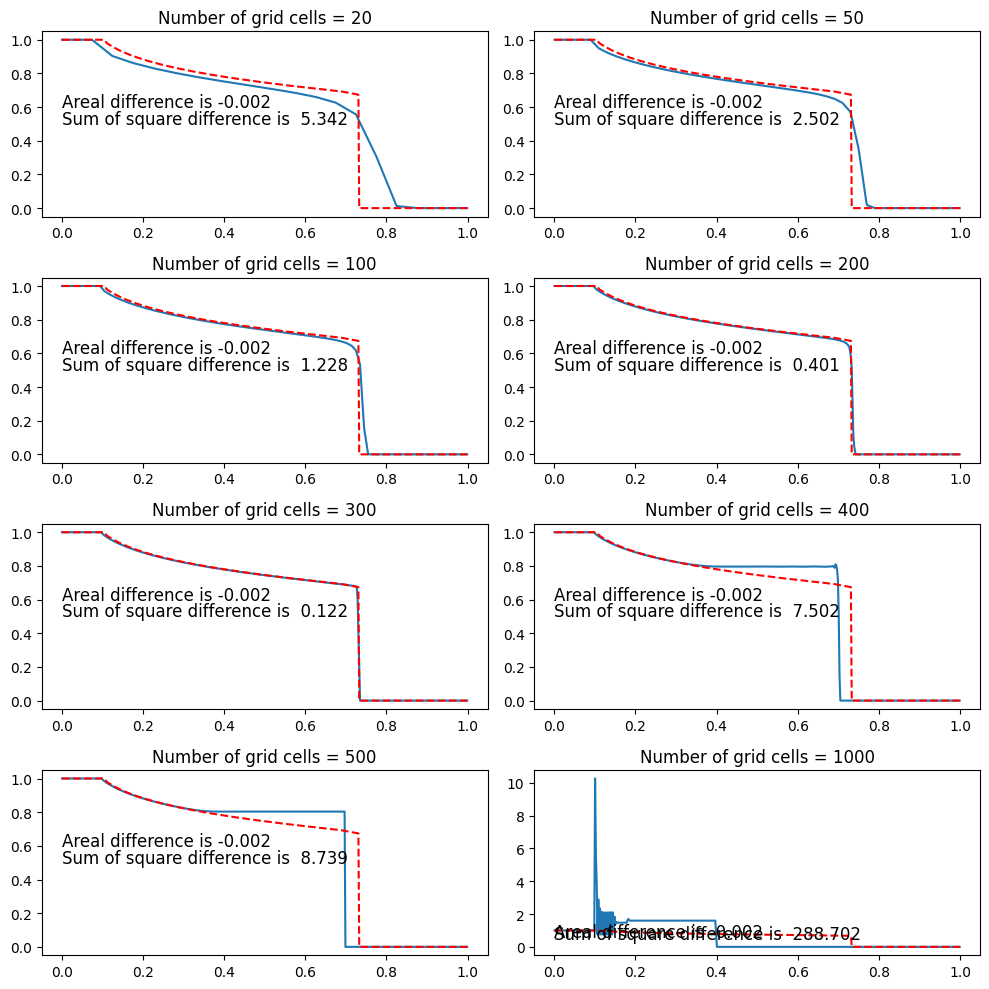

In [75]:
plt.figure(figsize=(10,10))

nx_all = [20, 50, 100, 200, 300, 400, 500, 1000]

for i, nxi in enumerate(nx_all):
    dx = length/nxi
    x_num = np.linspace(x_min + dx/2, x_max-dx/2, nxi)

    s0 = np.zeros(nxi)
    L1 = np.logical_and(x_num > 0 , x_num <= 0.1)
    L2 = np.logical_and(x_num > 0.1 , x_num <= 1)
    s0[L1] = 1
    s0[L2] = 0

    a = 1
    h = (dt/dx)*a
    
    u_num = Numerical(s0, h, nt, M)
    nx = 500
    dx = length/nx
    x = np.linspace(x_min + dx/2, x_max-dx/2, nx)
    u_sol = np.interp(x, xM, uM)
    u_num = np.interp(x, x_num, u_num[:,-1])

    plt.subplot(4,2,i+1)
    plt.plot(x, u_num)
    plt.plot(x, u_sol, '--r')
    plt.title(f'Number of grid cells = {nxi}')
    plt.text(0, 0.6, f'Areal difference is {np.sum((u_num-u_sol)*dx):.3f}', fontsize=12)
    plt.text(0, 0.5, f'Sum of square difference is  {np.sum((u_num-u_sol)**2):.3f}', fontsize=12)
    if a*dt > dx:
        plt.text(0, 0.5, 'Decrease dt', fontsize=12)

plt.tight_layout()

Here we observe what was expected. Sum of square difference between numeric and analytic solutions strictly decrease with increasing resolution (until numeric model breaks).
I could investigate further into this by changing dt systematically as well, but my submission is already late enough.
As for what is the optimal number of grid points, that would depend on what level of accuracy is required from the output vs. how important speed of computation is.
In this case the computation only takes a fraction of a second no matter the resolution, so I would say 300 looks like a good enough fit.

In [76]:
# Re-initializing setup for nx=300
nx = 300
dx = length/nx
x = np.linspace(x_min + dx/2, x_max-dx/2, nx)

s0 = np.zeros(nx)
L1 = np.logical_and(x > 0 , x <= 0.1)
L2 = np.logical_and(x > 0.1 , x <= 1)
s0[L1] = 1
s0[L2] = 0

h = (dt/dx)*a

Text(0, 0.5, 'Saturation')

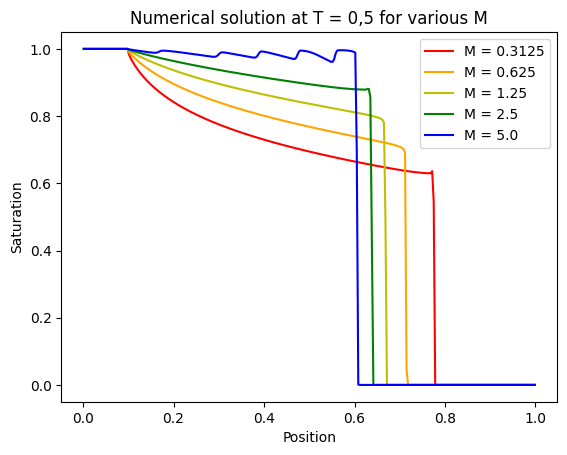

In [77]:
colors = ['r','orange','y','g','b']    
for i, mi in enumerate(M_all):
    plt.plot(x, Numerical(s0, h, nt, mi)[:,-1], color = colors[i], label=f'M = {mi}')
    plt.legend()
plt.title(f'Numerical solution at T = 0,5 for various M')
plt.xlabel('Position')
plt.ylabel('Saturation')

Since M = mu,water / mu,oil M < 1 means that the water has lower viscosity than the oil in front, and vica verca.
Viscosity of reservoir oil relies on density of the oil as well as temperature and pressure.
Viscosity of water also depends on temperature and pressure but is generally more stable.
Usually the viscosity of reservoir oil is higher than water, so we should pay most attention to M < 1.
The more mobile fluid, in our case water, will have a tendency to bypass the less mobile fluid.
For M > 1 we can see that a less mobile fluid will tend to push a larger portion of the more mobile fluid in front.

### Task 3 (i) - (iv) 

<img src="fig/part4.jpg" width=350><p style="font-size: 0.9em"><i></i></p>
<img src="fig/part5.jpg" width=350><p style="font-size: 0.9em"><i></i></p>
<img src="fig/part6.jpg" width=350><p style="font-size: 0.9em"><i></i></p>
<img src="fig/part7.jpg" width=350><p style="font-size: 0.9em"><i></i></p>

### Task 3 (v) 
From here we will use normalized Corey functions krw = s^nw and kro = (1 − s)^no for relative permeability curves with exponents equal to 1. Set viscosities µw and µo to be equal. Identify the function g(s) and make a plot of it.

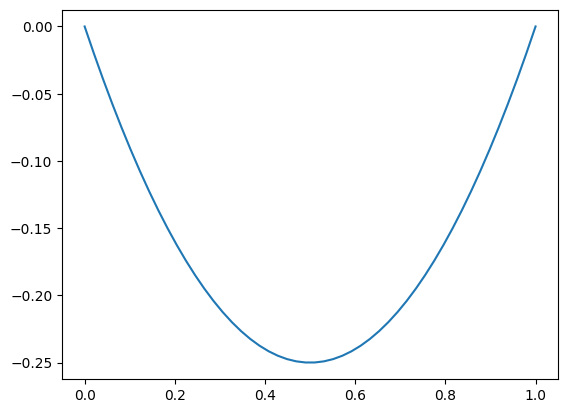

In [78]:
ns = 50 # nunmber of saturation grid points
s_all = np.linspace(0, 1, ns)

def g_s(s, m=1, nw=1, no=1):
    return -s**nw*(1-s)**no/(s**nw+m*(1-s)**no)

plt.plot(s_all, g_s(s_all))

We can see from the plot above that the flux function is strictly convex. 

Next we will compute the exact solution of the conservation law (*) with the two initial data (A) and (B), respectively. As no other information was given to other initial conditions, fluid / rock properties will be kept as previously mentioned in Task 3 and simulation time is set to 0.5.

In [79]:
# Initial data (A)

# Spatial grid
x_min = 0
x_max = 1
length = x_max - x_min
nx = 300
dx = length/nx
x = np.linspace(x_min + dx/2, x_max-dx/2, nx)

# Temporal grid
t_final = 0.5 

# Give Riemann data for jump

xR  = 0.5   # position of jump
v_l = 1     # u-value on left side of jump
v_r = 0     # u-value on right side of jump
nv = 50     # Number of values to divide jump, [vl,vr], into
f = g_s     # Specify f(u)
M = 1

Text(0, 0.5, 'Saturation')

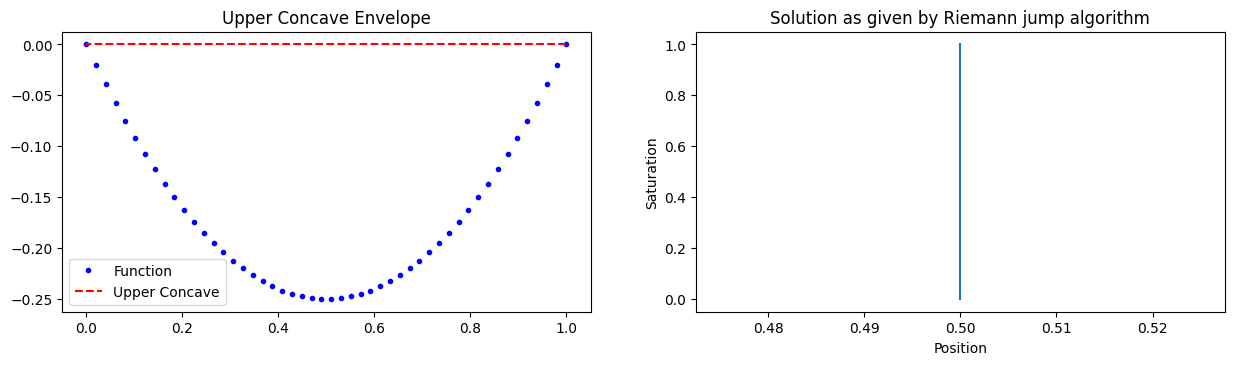

In [80]:
v, ev, ef, Label, xr = Riemann(xR, v_l, v_r, nv, f, M)

plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
plt.plot(v, f(v, M), 'b.', label = 'Function')
plt.plot(ev, ef, 'r--', label = Label)
plt.title(Label + ' Envelope')
plt.legend()

plt.subplot(2,2,2)
plt.plot(xr, ev)
plt.title('Solution as given by Riemann jump algorithm')
plt.xlabel('Position')
plt.ylabel('Saturation')

Text(0, 0.5, 'Saturation')

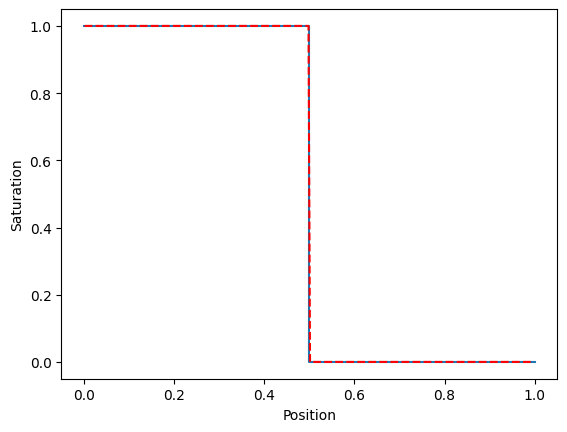

In [81]:
xM = np.concatenate(([x_min], xr, [x_max]))
uM = np.concatenate(([1], ev, [0]))

u_sol = np.interp(x, xM, uM)

plt.plot(xM, uM)
plt.plot(x, u_sol, '--r')
plt.xlabel('Position')
plt.ylabel('Saturation')

While transforming to dimensionless parameters delta_rho was assumed to be a positive quantity, which in turn means that we have assumed water to be more dens than oil. In this initial state the water starts at the bottom of the vertical core plug, and we are not surprised to find that is stays there, while gravity is the only driving force in this system.

In [82]:
# Initial data (B)

v_l = 0    
v_r = 1    

Text(0, 0.5, 'Saturation')

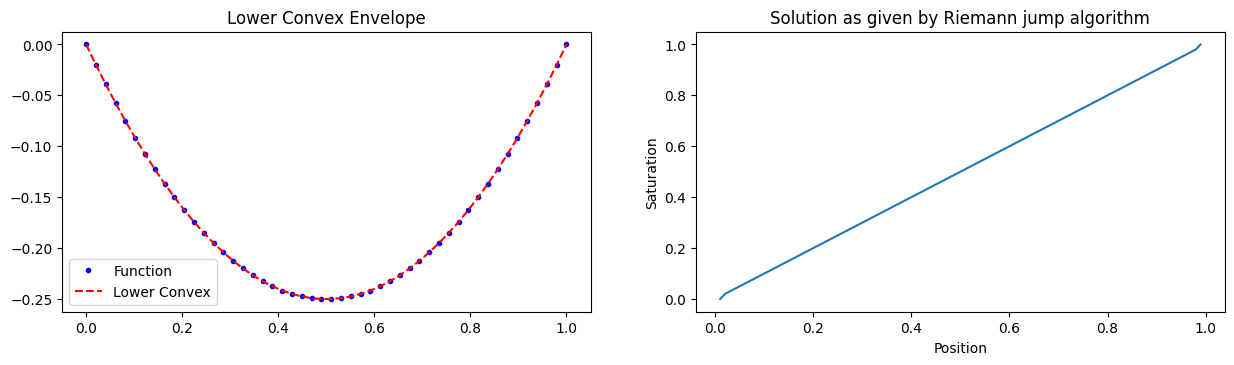

In [83]:
v, ev, ef, Label, xr = Riemann(xR, v_l, v_r, nv, f, M)

plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
plt.plot(v, f(v, M), 'b.', label = 'Function')
plt.plot(ev, ef, 'r--', label = Label)
plt.title(Label + ' Envelope')
plt.legend()

plt.subplot(2,2,2)
plt.plot(xr, ev)
plt.title('Solution as given by Riemann jump algorithm')
plt.xlabel('Position')
plt.ylabel('Saturation')

Text(0, 0.5, 'Saturation')

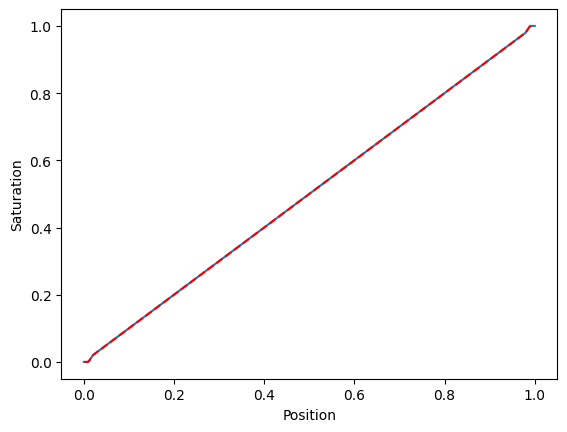

In [84]:
xM = np.concatenate(([x_min], xr, [x_max]))
uM = np.concatenate(([0], ev, [1]))

u_sol = np.interp(x, xM, uM)

plt.plot(xM, uM)
plt.plot(x, u_sol, '--r')
plt.xlabel('Position')
plt.ylabel('Saturation')

In initial state (B) the water starts in the top half of the core plug and here we can see the saturation profile at time 0.5. By some coincidence it seems that the first water droplet just reached the bottom of the core at this point. To further the solution through time from this point correctly, new jumps would have to be introduced.

Following we will investigate what this curve looks like at an intermediate earlier time and at a slightly later time to try and verify the interpretation of the above graph.

Text(0, 0.5, 'Saturation')

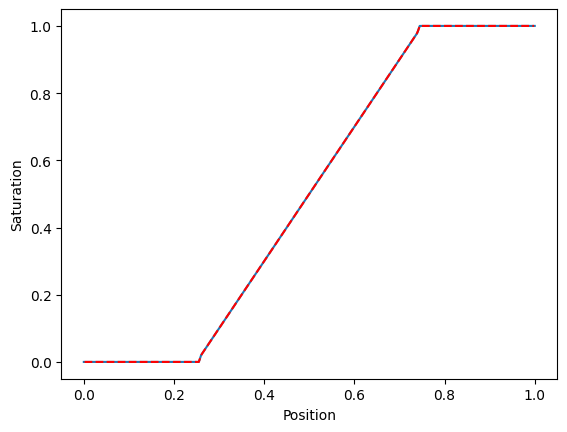

In [85]:
t_final = 0.25

v, ev, ef, Label, xr = Riemann(xR, v_l, v_r, nv, f, M)
xM = np.concatenate(([x_min], xr, [x_max]))
uM = np.concatenate(([0], ev, [1]))

u_sol = np.interp(x, xM, uM)

plt.plot(xM, uM)
plt.plot(x, u_sol, '--r')
plt.xlabel('Position')
plt.ylabel('Saturation')


Pretty much as expected, the intermediate time expresses as an intermediate saturation profile between the initial state and T = 0.5.

Text(0, 0.5, 'Saturation')

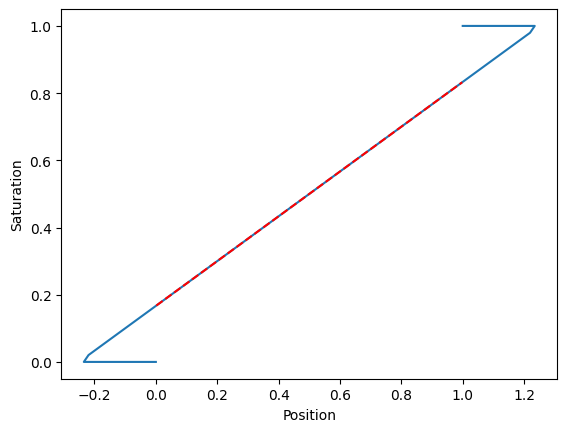

In [86]:
t_final = 0.75

v, ev, ef, Label, xr = Riemann(xR, v_l, v_r, nv, f, M)
xM = np.concatenate(([x_min], xr, [x_max]))
uM = np.concatenate(([0], ev, [1]))

u_sol = np.interp(x, xM, uM)

plt.plot(xM, uM)
plt.plot(x, u_sol, '--r')
plt.xlabel('Position')
plt.ylabel('Saturation')

As is shown in the above plot, moving beyond the breaking point of this model would require setting up a new description of shock waves to continue plotting physical results.